# Plant Seedlings Classification - TensorFlow Project
by: miguelcecci

The propouse of this model is classify 12 species of seedlings. It consists in a Convolutional Neural Net built using 2 conv layers and 2 full connected hidden layers. The input of the network is a 56x56x3 matrix and outputs a 12 elements array wich represents a class of the seedling.

Data used to train the model -> https://www.kaggle.com/c/plant-seedlings-classification

SPOILER: only 70% accuracy

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
%matplotlib inline
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
import random
import glob
from IPython.display import Image
import cv2

In [2]:
print("Tensorflow Version",tf.__version__)

Tensorflow Version 1.3.0


In [3]:
IMG_SIZE = (56, 56)
COLOR_CHANNELS = 3

## Load Sample

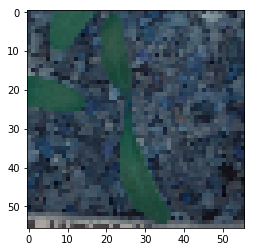

In [4]:
sample = cv2.resize(cv2.imread('../data/SeedlingData/train/Sugar beet/1347ac5ac.png'), IMG_SIZE)
plt.imshow(sample)

### Image Equalization

In [5]:
def histogram_equalize(img):
    if(COLOR_CHANNELS == 1):
        return cv2.equalizeHist(img)
        
    b, g, r = cv2.split(img)
    red = cv2.equalizeHist(r)
    green = cv2.equalizeHist(g)
    blue = cv2.equalizeHist(b)
    return cv2.merge((blue, green, red))

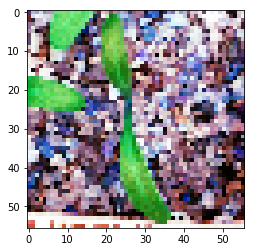

In [6]:
sample = histogram_equalize(sample)
plt.imshow(sample)

## Augmentation Functions
Rotate and zooming to increase the diversity of the data

### - Random Rotation

In [7]:
def random_rotate(img):
    num_rows, num_cols = img.shape[:2]
    rotation_matrix = cv2.getRotationMatrix2D((num_cols/2, num_rows/2), random.randrange(360), 1)
    img_rotation = cv2.warpAffine(img, rotation_matrix, (num_cols, num_rows))
    return img_rotation

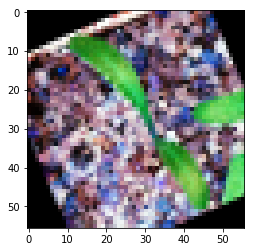

In [8]:
sample = random_rotate(sample)
plt.imshow(sample)

### - Random Zoom

In [9]:
def random_zoom(img):
    x1, y1 = random.randrange(0, 6), random.randrange(0, 6)
    x2, y2 = random.randrange(50, 56), random.randrange(50, 56)
    img = img[y1:y2, x1:x2]
    img = cv2.resize(img, IMG_SIZE)
    return img

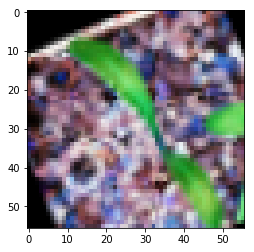

In [10]:
sample = random_zoom(sample)
plt.imshow(sample)

## Data

### - One Hot labels

In [11]:
dirs = ['Black-grass', 'Charlock', 'Cleavers', 'Common Chickweed', 'Common wheat', 'Fat Hen', 'Loose Silky-bent',
       'Maize', 'Scentless Mayweed', 'Shepherds Purse', 'Small-flowered Cranesbill', 'Sugar beet']
values = np.array(dirs)
# print(values,'\n')

#transformando em one hot
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(values)
onehot_encoder = OneHotEncoder(sparse=False)

integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
onehot_encodeded = np.array(onehot_encoder.fit_transform(integer_encoded)).astype(int)
print(onehot_encodeded)

[[1 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 0 0 0 1]]


### - Training Data

In [12]:
training_path = '../data/SeedlingData/train/'
training_data = []
__ = -1;
for img_class in dirs:
    __ += 1
    for filename in glob.glob(training_path+img_class+'/*.png'):
        im = cv2.imread(filename)
        im = histogram_equalize(np.array(cv2.resize(im, IMG_SIZE)))
        training_data.append([im, onehot_encodeded[__]])
random.shuffle(training_data)
print(len(training_data))

4750


### - Cross Validation - Validation Data
Spliting the data into validation set and training set

In [13]:
validation_data, validation_label = [], []
validation_set_percentage = 0.15
validation = training_data[-int(validation_set_percentage*len(training_data)):]
training_data = training_data[:-int(validation_set_percentage*len(training_data))]
for i in range(len(validation)):
    validation_data.append(validation[i][0].ravel())
    validation_label.append(validation[i][1])

### - Test Data

In [14]:
test_path = '../data/SeedlingData/test/'
test_data = []
for filename in glob.glob(test_path+'/*.png'):
    im = cv2.imread(filename)
    im = histogram_equalize(np.array(cv2.resize(im, IMG_SIZE))).ravel()
    test_data.append([im, filename.split('/')[-1]])

## Building Model

In [15]:
def init_weights(shape):
    init_random_dist = tf.truncated_normal(shape, stddev = 0.1)
    return tf.Variable(init_random_dist)

In [16]:
def init_bias(shape):
    init_bias_vals = tf.constant(0.1, shape=shape)
    return tf.Variable(init_bias_vals)

In [17]:
def conv2d(x, W):
    #x -> [batch, H, W, Channels]
    #W -> [filter H, filter W, Channels IN, Channels Out]
    return tf.nn.conv2d(x, W, strides = [1,1,1,1], padding='SAME')

In [18]:
def max_pool_2by2(x):
    #x -> [batch, H, W, Channels]
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides = [1,2,2,1], padding='SAME')

In [19]:
def convolutional_layer(input_x, shape):
    W = init_weights(shape)
    b = init_bias([shape[3]])
    return tf.nn.relu(conv2d(input_x, W)+b)

In [20]:
def normal_full_layer(input_layer, size):
    input_size = int(input_layer.get_shape()[1])
    W = init_weights([input_size, size])
    b = init_bias([size])
    return tf.matmul(input_layer, W) + b

In [21]:
# placeholders
x = tf.placeholder(tf.float32, shape=[None, IMG_SIZE[0]*IMG_SIZE[1]*COLOR_CHANNELS])
y_ = tf.placeholder(tf.float32, shape=[None, 12])

In [22]:
#layers
x_image = tf.reshape(x, [-1, IMG_SIZE[0], IMG_SIZE[1], COLOR_CHANNELS])

In [23]:
convo_1 = convolutional_layer(x_image, shape=[5,5,COLOR_CHANNELS,32])
convo_1_pooling = max_pool_2by2(convo_1)

In [24]:
convo_2 = convolutional_layer(convo_1_pooling, shape=[5,5,32,64])
convo_2_pooling = max_pool_2by2(convo_2)

In [25]:
convo_2_flat = tf.reshape(convo_2_pooling, [-1, 14*14*64])

In [26]:
full_layer_one = tf.nn.relu(normal_full_layer(convo_2_flat, 1048))

In [27]:
#dropout
hold_prob = tf.placeholder(tf.float32)
full_one_dropout = tf.nn.dropout(full_layer_one, keep_prob=hold_prob)

In [28]:
full_layer_two = tf.nn.relu(normal_full_layer(full_layer_one, 1048))

In [29]:
full_two_dropout = tf.nn.dropout(full_layer_two, keep_prob=hold_prob)

In [30]:
y_pred = normal_full_layer(full_two_dropout, 12)

In [31]:
#Loss
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y_pred))

In [32]:
#Optimizer
optimizer = tf.train.AdamOptimizer(learning_rate=0.001)
train = optimizer.minimize(cross_entropy)

## Batch Loader
Load the batch and randomly rotate and crop image

In [33]:
def load_batch(size):
    batch_x, batch_y = [],[]
    for _ in range(size):
            rand_val = random.randrange(0,len(test_data))
            batch_x.append(random_zoom(random_rotate(training_data[rand_val][0])).ravel())
            batch_y.append(training_data[rand_val][1])
    return batch_x, batch_y    

## Runing Session
~30 min using gtx 1080

In [34]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [35]:
steps = 40000

In [36]:
plot_data = []
batch_size = 100

with tf.Session() as sess:
    sess.run(init)
    for i in range(steps):
        batch_x, batch_y = load_batch(batch_size)
        batch_x = np.array(batch_x)
        batch_y = np.array(batch_y)
        feed = {x:batch_x, y_:batch_y, hold_prob:0.5}
        sess.run(train, feed_dict = feed)
        
        if i%100 == 0:
            temp_plot = sess.run(cross_entropy, feed_dict = feed)
            
            matches = tf.equal(tf.argmax(y_pred, 1), tf.argmax(y_, 1))
            acc = tf.reduce_mean(tf.cast(matches, tf.float32))
            accuracy = sess.run(acc, feed_dict={x:validation_data, y_:validation_label, hold_prob:1.0})
            plot_data.append([temp_plot, accuracy])
            if i%1000 == 0:
                print('>  ON STEP: {:8} - COST: {: 16.6f} - ACCURACY: {: >#16.6f}'.format(i, temp_plot, accuracy))
            
    #saving trained model
    save_path = saver.save(sess, "./seedlings-model.ckpt")
    print("Model saved in path: %s" % save_path)

>  ON STEP:        0 - COST:     19574.853516 - ACCURACY:         0.136236
>  ON STEP:     1000 - COST:         2.408959 - ACCURACY:         0.136236
>  ON STEP:     2000 - COST:         2.385241 - ACCURACY:         0.139045
>  ON STEP:     3000 - COST:         2.444038 - ACCURACY:         0.143258
>  ON STEP:     4000 - COST:         2.399483 - ACCURACY:         0.140449
>  ON STEP:     5000 - COST:         2.312799 - ACCURACY:         0.212079
>  ON STEP:     6000 - COST:         2.265729 - ACCURACY:         0.224719
>  ON STEP:     7000 - COST:         2.276121 - ACCURACY:         0.223315
>  ON STEP:     8000 - COST:         2.220963 - ACCURACY:         0.245786
>  ON STEP:     9000 - COST:         2.128776 - ACCURACY:         0.255618
>  ON STEP:    10000 - COST:         2.230093 - ACCURACY:         0.262640
>  ON STEP:    11000 - COST:         2.102083 - ACCURACY:         0.226124
>  ON STEP:    12000 - COST:         2.087006 - ACCURACY:         0.254213
>  ON STEP:    13000 - CO

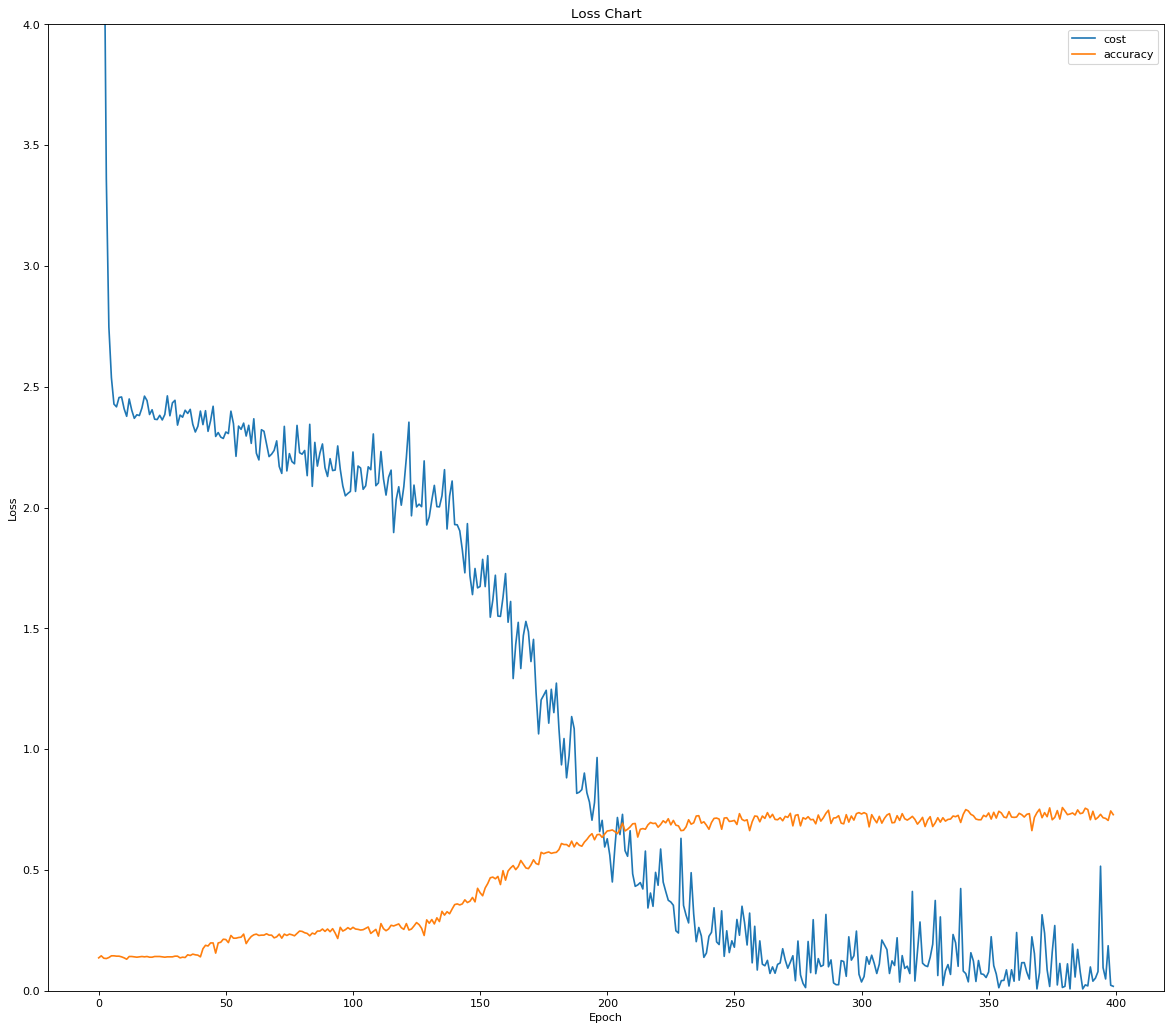

In [37]:
plot_data = np.array(plot_data).transpose()
fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
plt.ylim(0,4)
plt.title('Loss Chart')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(plot_data[0], label="cost")
plt.plot(plot_data[1], label="accuracy")
plt.legend(loc='upper right')

In [39]:
outs_ = []
with tf.Session() as sess:    
    saver = tf.train.import_meta_graph('seedlings-model.ckpt.meta')
    saver.restore(sess,tf.train.latest_checkpoint('./'))
    graph = tf.get_default_graph()
    x = graph.get_tensor_by_name("Placeholder:0")
    for i in range(len(test_data)):
        feed ={x: [test_data[i][0]], hold_prob:1}

        op_to_restore = tf.nn.softmax(graph.get_tensor_by_name("add_4:0"))

        aaa = sess.run(op_to_restore, feed).ravel().tolist()
        aaa = aaa.index(max(aaa))
        outs_.append([test_data[i][1], dirs[aaa]])

INFO:tensorflow:Restoring parameters from ./seedlings-model.ckpt


## Writing csv submition

In [40]:
import csv
with open('submition.csv', 'w') as csvfile:
    fieldnames = ['file', 'species']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    
    writer.writeheader()
    for i in range(len(outs_)):
        writer.writerow({'file': outs_[i][0], 'species':outs_[i][1]})
    print("csv file ready")

csv file ready
